In [1]:
!pip install datasets

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer
from transformers.models.m2m_100.modeling_m2m_100 import M2M100Encoder
device = "cuda" if torch.cuda.is_available() else "cpu"

### language identification model

In [8]:
class ClassifierHead(nn.Module):
    def __init__(self,):
        super().__init__()
        self.layers = nn.Sequential(
            nn.LayerNorm(1024),
            nn.Linear(1024, 20)
        )

    def forward(self, x):
        logits = self.layers(x)
        return logits

class LIDModel(nn.Module):
    def __init__(self, encoder, classifier):
        super().__init__()
        self.encoder = encoder
        self.classifier = classifier

    def forward(self, input_ids, attention_mask):
        enc_out = self.encoder(input_ids, attention_mask)
        lhs = enc_out.last_hidden_state
        mean_emb = (lhs * attention_mask.unsqueeze(-1)).sum(1) / attention_mask.unsqueeze(-1).sum(1)
        logits = self.classifier(mean_emb)
        return logits

In [6]:
# encoder
model_name = "cointegrated/SONAR_200_text_encoder"
encoder = M2M100Encoder.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

for p in encoder.parameters():
    p.requires_grad = False

In [9]:
# classifier
classifier = ClassifierHead()

In [10]:
# lid model
model = LIDModel(encoder, classifier).to(device)
print(model)
num_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad==True)
print(f"{num_params=} | {trainable_params=} ({round(trainable_params * 100 / num_params, 4)}%)")

LIDModel(
  (encoder): M2M100Encoder(
    (embed_tokens): M2M100ScaledWordEmbedding(256206, 1024, padding_idx=1)
    (embed_positions): M2M100SinusoidalPositionalEmbedding()
    (layers): ModuleList(
      (0-23): 24 x M2M100EncoderLayer(
        (self_attn): M2M100Attention(
          (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
          (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        )
        (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (activation_fn): ReLU()
        (fc1): Linear(in_features=1024, out_features=8192, bias=True)
        (fc2): Linear(in_features=8192, out_features=1024, bias=True)
        (final_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      )
    )
    (layer_norm): LayerNorm((1024,), eps=1e-05, element

### language identification dataset

In [11]:
ds = load_dataset("papluca/language-identification")
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

In [12]:
id2label = sorted(list(set(train_ds['labels'])))
label2id = {x: idx for idx, x in enumerate(id2label)}
print(label2id)

{'ar': 0, 'bg': 1, 'de': 2, 'el': 3, 'en': 4, 'es': 5, 'fr': 6, 'hi': 7, 'it': 8, 'ja': 9, 'nl': 10, 'pl': 11, 'pt': 12, 'ru': 13, 'sw': 14, 'th': 15, 'tr': 16, 'ur': 17, 'vi': 18, 'zh': 19}


In [13]:
def process_fn(x):
    x['labels'] = [label2id[label] for label in x['labels']]
    return x

ds = ds.map(process_fn, batched=True)

In [14]:
train_ds = ds['train']
val_ds = ds['validation']
test_ds = ds['test']

train_ds[0]

{'labels': 12,
 'text': 'os chefes de defesa da estónia, letónia, lituânia, alemanha, itália, espanha e eslováquia assinarão o acordo para fornecer pessoal e financiamento para o centro.'}

In [15]:
def collate_fn(batch):
    batch_tok = tokenizer([x['text'] for x in batch], padding=True, truncation=True, return_tensors="pt").to(device)
    labels = torch.tensor([x['labels'] for x in batch], dtype=torch.int64).to(device)
    return batch_tok, labels

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)

In [17]:
def evaluate(model, ds, batch_size=32, eval_steps=40):
    loss_ls, acc_ls = [], []
    
    model.eval()
    dl = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn)
    
    with torch.no_grad():
        for idx, (model_inputs, labels) in enumerate(dl):
            logits = model(**model_inputs)
            loss = loss_fn(logits, labels)
            loss_ls.append(loss.item())
    
            preds = logits.argmax(dim=1)
            accuracy = (preds==labels).sum() / batch_size
            acc_ls.append(accuracy.item())
    
            if idx == eval_steps - 1:
                break
    
    model.train()
    
    mean_loss, mean_accuracy = sum(loss_ls) / len(loss_ls), sum(acc_ls) / len(acc_ls)
    return mean_loss, mean_accuracy

In [18]:
def train(model, ds, val_ds, batch_size=32, train_steps=-1, val_steps=100, val_freq=200):
    size = (train_steps * batch_size) if train_steps != -1 else len(ds)
    loss_ls, acc_ls, val_loss_ls, val_acc_ls = [], [], [], []
    
    model.train()
    dl = DataLoader(ds, batch_size=batch_size, collate_fn=collate_fn)
    for idx, (model_inputs, labels) in enumerate(dl):

        # loss
        logits = model(**model_inputs)
        loss = loss_fn(logits, labels)
        loss_ls.append(loss.item())

        # accuracy
        preds = logits.argmax(dim=1)
        accuracy = (preds==labels).sum().item() / batch_size
        acc_ls.append(accuracy)
    
        if idx % 40 == 0:
            current = idx * batch_size + labels.shape[0]
            print(f"loss: {loss:>7f} accuracy: {accuracy:>7f} [{current:>5d}/{size:>5d}]")

        # update step
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # validation
        if idx % val_freq == 0:
            eval_loss, eval_accuracy = evaluate(model, val_ds, batch_size, val_steps)
            val_loss_ls.append(eval_loss) 
            val_acc_ls.append(eval_accuracy)
            print(f"\nval_loss: {eval_loss:>7f} val_accuracy: {eval_accuracy:>7f}\n")

        if idx == train_steps - 1:
            break

    return {
        "train_loss": loss_ls,
        "train_accuracy": acc_ls,
        "val_loss": val_loss_ls,
        "val_accuracy": val_acc_ls,
    }

In [19]:
history = train(model, train_ds, val_ds, batch_size=32, train_steps=-1, val_steps=100, val_freq=200)

loss: 3.098095 accuracy: 0.062500 [   32/70000]

val_loss: 3.134351 val_accuracy: 0.046875

loss: 2.646182 accuracy: 0.281250 [ 1312/70000]
loss: 2.239307 accuracy: 0.375000 [ 2592/70000]
loss: 1.778678 accuracy: 0.625000 [ 3872/70000]
loss: 1.512447 accuracy: 0.718750 [ 5152/70000]
loss: 1.248198 accuracy: 0.656250 [ 6432/70000]

val_loss: 1.727819 val_accuracy: 0.538750

loss: 1.116101 accuracy: 0.843750 [ 7712/70000]
loss: 1.164471 accuracy: 0.812500 [ 8992/70000]
loss: 0.885212 accuracy: 0.812500 [10272/70000]
loss: 0.683121 accuracy: 0.937500 [11552/70000]
loss: 1.072003 accuracy: 0.750000 [12832/70000]

val_loss: 1.345954 val_accuracy: 0.631250

loss: 0.963121 accuracy: 0.781250 [14112/70000]
loss: 0.682800 accuracy: 0.906250 [15392/70000]
loss: 0.803277 accuracy: 0.875000 [16672/70000]
loss: 0.651255 accuracy: 0.937500 [17952/70000]
loss: 0.557000 accuracy: 0.875000 [19232/70000]

val_loss: 1.173080 val_accuracy: 0.663750

loss: 0.613623 accuracy: 0.937500 [20512/70000]
loss: 0.

In [26]:
import matplotlib.pyplot as plt
def plot(name, ls, avg_len=10):
    history = [torch.tensor(ls[idx: idx + avg_len]).mean().item() for idx in range(0, len(ls), avg_len)]
    plt.plot(range(len(history)), history)
    plt.xlabel(f"step / {avg_len}")
    plt.ylabel(name)
    plt.title(f"{name} curve")
    plt.show()

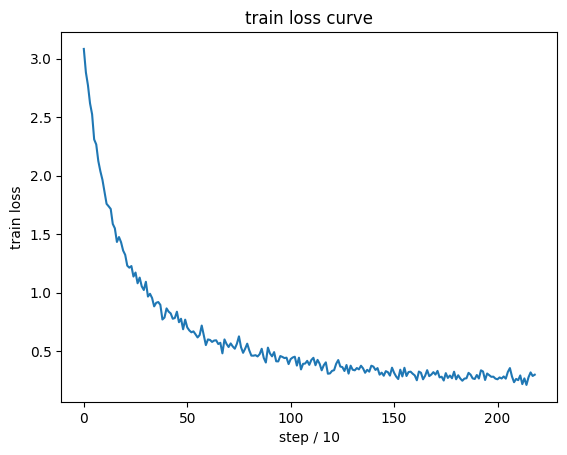

In [27]:
plot("train loss", history['train_loss'], avg_len=10)

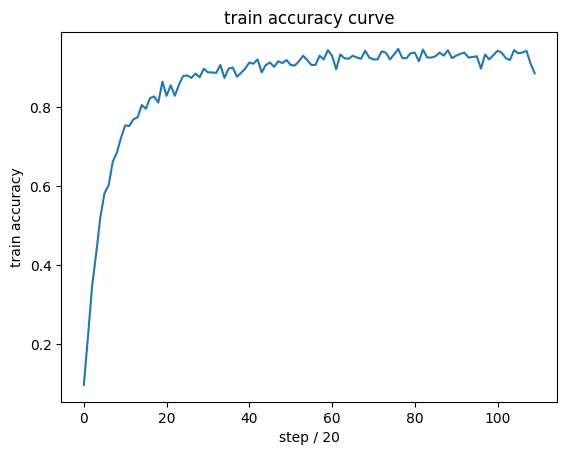

In [28]:
plot("train accuracy", history['train_accuracy'], avg_len=20)

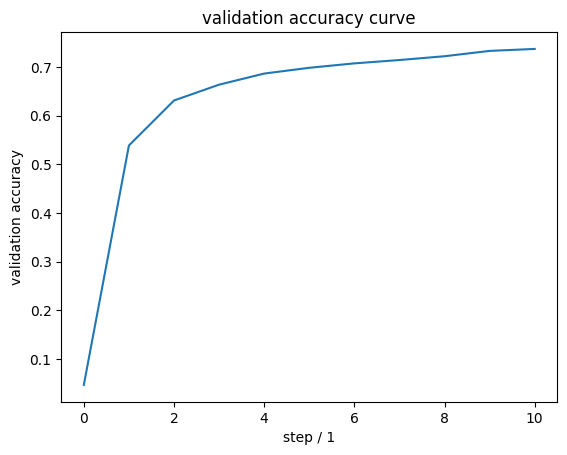

In [29]:
plot("validation accuracy", history['val_accuracy'], avg_len=1)

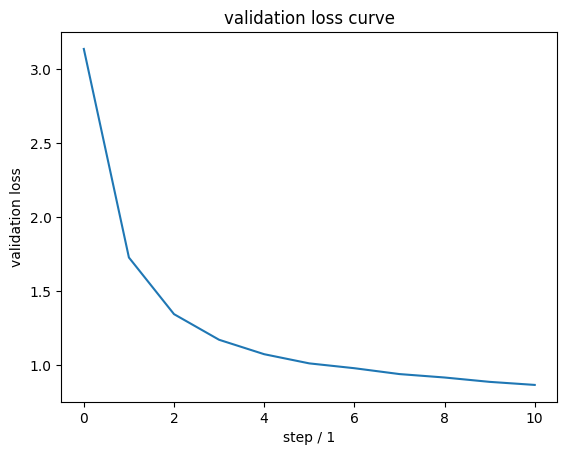

In [30]:
plot("validation loss", history['val_loss'], avg_len=1)

In [31]:
# inference

model.eval()
idx = 6
print(train_ds[idx])
seq = train_ds[idx]['text']
tok = tokenizer(seq, return_tensors="pt").to("cuda")
logits = model(**tok)
probs = F.log_softmax(logits, dim=1)
print(f"argmax = {probs.argmax(dim=1).item()}")

{'labels': 17, 'text': 'اس کے بارے میں ، سفید شادی کی شرح کے بعد سفید اورنمایاں طور پر سفید اورنمایاں طور پر .'}
argmax = 16


In [32]:
# save model checkpoint

torch.save(model.state_dict(), "model.pth")